**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1a) Load the dataset and implement the K Means algorithm. You need to find the optimal number of clusters using the
> i) elbow method

> ii) silhoette method



1b) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

1c) Experiment with different distance measures [Euclidean distance, Manhattan distance].

1d) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.


1e) Visualize the dataset to depict the clusters formed. (prefer T-SNE)

</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset.

2a) visualize a dendogram and find out the optimal number of clusters with the help of Dendogram. Explain the procedure.


2b) Implement Hierarchical clustering using: </br>
> i) single linkage

> ii) Complete linkage

>Visualize the clusters obtained using these linkages and compare. 



In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# compute the euclidean distance between two points
# each point is a vector of dimension 'n'*'n'
def euclideanDistance(pt1, pt2):
    d1 = np.subtract(pt1, pt2)
    d2 = np.multiply(d1,d1)
    dist = np.sum(d2)
    return math.sqrt(dist)

# compute the squared distance between two points
# each point is a vector of dimension 'n'*'n'
def squaredDistance(pt1, pt2):
    d1 = np.subtract(pt1, pt2)
    d2 = np.multiply(d1,d1)
    dist = np.sum(d2)
    return dist

# compute the manhattan distance between two points
# each point is a vector of dimension 'n'*'n'
def manhattanDistance(pt1, pt2):
    d1 = np.subtract(pt1, pt2)
    d2 = np.absolute(d1)
    dist = np.sum(d2)
    return dist


In [37]:
import random

#implement Kmeans from scratch
class myKmeans:
  
  def __init__(self, num_clusters, data, init_method, distanceFunction):
    m, numFeatures  = data.shape
    # print("#Data points ", m, " number of features ", numFeatures)
    self.num_clusters = num_clusters
    self.clustermembership = np.zeros(m, dtype=int) # for each point stores the cluster membership
    self.clusterCenters = np.zeros((self.num_clusters,numFeatures)) # cluster centers 

    # initialization of cluster membership as random
    if init_method == 'random':
      for j in range(m):
          r1 = round(random.randint(0, num_clusters)) 
          if r1 < num_clusters:
            self.clustermembership[j] = r1
          else:
            self.clustermembership[j] = num_clusters -1

    elif init_method == 'forgy':
      # other method supported is forgy, randomly assign points as cluster centers
      for j in range(num_clusters):
        selectPt = random.randint(0, m)
        self.clusterCenters[j] = data[selectPt]

      self.clustermembership, totaldistance = self.getClusterMembership(data, self.clusterCenters, self.num_clusters, distanceFunction)

    else:
      # neither random nor forgy method of initialization
      print("error encountered")


  # define cluster memberships now, find nearest cluster center to each point and update cluster membership
  def getClusterMembership(self, X, clusterCenters, K, distanceFunction):
    totalDistance = 0
    m, n = X.shape
    clustermembership = np.zeros(len(X), dtype=int)
    for i in range(m):
      minDist = math.inf
      for j in range(K):
        try:
          if (distanceFunction == 'euclidean'):
            dist = euclideanDistance(clusterCenters[j], X[i])
          else:
            dist = manhattanDistance(clusterCenters[j], X[i])
        except:
          print("error", clusterCenters.shape)
          print("error", clusterCenters[j])
          # dist = 0

        if (dist < minDist):
          clustermembership[i] = j
          minDist = dist

      totalDistance += minDist
    return clustermembership, totalDistance

  # Iterate over defined number of times or till errorThreshold is reached
  def iterate(self, data, clusterCenters, clustermembership, num_clusters, distanceFunction, numIterations, errorThreshold):
    prevTotalDistance = math.inf
    feat_cols = [ 'pixel'+str(i) for i in range(data.shape[1]) ]
    df = pd.DataFrame(data,columns=feat_cols)
    df['clusterMember'] = clustermembership[:]

    for i in range(0, numIterations):
      #find new cluster centers
      df['clusterMember'] = clustermembership[:]
      clusterCenters = df.groupby('clusterMember').mean().to_numpy()

      p,q = clusterCenters.shape
      while (p < num_clusters):
        # print("number of clusters less than Total Number Required", p, q, num_clusters)
        selectPt = random.randint(0, data.shape[0])
        clusterCenters = np.append(clusterCenters, data[selectPt]).reshape(p+1, q)
        # print(clusterCenters.shape)
        p,q = clusterCenters.shape

      # Assign new memberships
      clustermembership, totalDistance = self.getClusterMembership(data, clusterCenters, num_clusters, distanceFunction)

      # check errorThreshold and then iterate again or break
      # print("total distance ", totalDistance, " iteration ", i)
      if abs(prevTotalDistance - totalDistance) < errorThreshold :
        print("Equilibrium reached - number of iterations and total distance", i, totalDistance)
        break
      else:
        prevTotalDistance = totalDistance

    df['clusterMember'] = clustermembership[:]
    clusterCenters = df.groupby('clusterMember').mean().to_numpy()

    return clusterCenters, clustermembership

In [40]:
from keras.datasets import fashion_mnist
(trainX, trainy), (t1, testy) = fashion_mnist.load_data()

In [41]:
print(trainX.shape)
print(t1.shape)

(60000, 28, 28)
(10000, 28, 28)


In [42]:
t1 = np.reshape(t1, (10000, 28*28), 'C')
X = t1
t1 = t1[5000:]

In [43]:
t1mean = t1.mean(axis=0)
t1std = t1.std(axis=0)
t1= np.subtract(t1, t1mean)
t1 = np.divide(t1, t1std)


In [7]:
t1.shape

(5000, 784)

In [44]:
t1mean = X.mean(axis=0)
t1std = X.std(axis=0)
X = np.subtract(X, t1mean)
X = np.divide(X, t1std)
y = testy[:10000]
y.shape

(10000,)

In [8]:
#implement elbow method from scratch

import pandas as pd
def elbow(numClusters, data, clusterCenters, clustermembership, distanceFunction):
    ccenter = [] 
    distance = 0
    numPoints = len(data)
    #compute distance for each point from its cluster centers
    for j in range(0, numPoints):
        # identify the clustermembership and get its cluster center
        ccenter = clusterCenters[clustermembership[j]]
        
        if (distanceFunction == 'euclidean'):
            dist = euclideanDistance(ccenter, data[j])
        else:
            dist = manhattanDistance(ccenter, data[j])

        distance += dist ** 2
    
    return distance

In [9]:
def errorMeasure(data, st_num, end_num, distanceFunction, init_method, pairedDistance):
    numIterations = 100
    errorThreshold = 0.001
    # distanceFunction = 'euclidean'
    wcss = list()
    silhouetteMeasure = list()
    num_clus = list()

    for num_clusters in range(st_num,end_num):
      print("num Clusters", num_clusters)
      num_clus.append(num_clusters)
      kmean = myKmeans(num_clusters, data, init_method, distanceFunction)
      clustCenters, ymeans = kmean.iterate(data, kmean.clusterCenters, kmean.clustermembership, num_clusters, distanceFunction, numIterations, errorThreshold)
      w1 = elbow(num_clusters, data, clustCenters, ymeans, distanceFunction)
      wcss.append(w1)
      print("wcss", num_clusters, w1)
      sil = silhouetteNP(num_clusters, data, clustCenters, ymeans, pairedDistance)
      silhouetteMeasure.append(sil)
      print("sil", num_clusters, sil)       
    plt.plot(num_clus, wcss)
    plt.show()
    plt.plot(num_clus, silhouetteMeasure)
    plt.show()
    return wcss, silhouetteMeasure



In [10]:
#implement silhouette method from scratch
def silhouetteNP(numClusters, data, clusterCenters, clustermembership, pairedDistance):
    numPoints = len(data)
    sil = np.zeros(numPoints)
    feat_cols = [ 'pixel'+str(i) for i in range(pairedDistance.shape[1]) ]
    df = pd.DataFrame(pairedDistance,columns=feat_cols)
    df['clusterMember'] = clustermembership[:]

    # print(df.shape)
    means = df.groupby('clusterMember').mean()
    # print(means['pixel'+str(1)])
    #compute distance for each point basis cluster membership
    for pt in range(0, numPoints):
      ptcluster = clustermembership[pt]
      minDistance = np.inf
      for j in range(0, numClusters):
        if j != ptcluster:
          meanOtherCluster = means.at[j, 'pixel'+str(pt)]
          if (meanOtherCluster < minDistance ):
            minDistance = meanOtherCluster
        else:
          averageSameCluster = means.at[j, 'pixel'+str(pt)]

      sil[pt] = (minDistance - averageSameCluster) / max(minDistance, averageSameCluster)

    return np.average(sil)

In [11]:
def pairedDistanceMatrix(data, distanceFunction):   
    numPoints = len(data)
    distance = np.zeros((numPoints, numPoints), dtype='float')
    print("starting paired Distance matrix", numPoints)
    #compute distance for each point from its cluster centers
    for i in range(0, numPoints):
      for j in range(i, numPoints):
        # identify the clustermembership and get its cluster center
        if (distanceFunction == 'euclidean'):
          distance[i][j] = euclideanDistance(data[i], data[j])
        else:
          distance[i][j] = manhattanDistance(data[i], data[j])
        distance[j][i] = distance[i][j]
        
    return distance

In [12]:
pairedDistance_euclidean = pairedDistanceMatrix(t1, 'euclidean')


starting paired Distance matrix 5000


num Clusters 5
Equilibrium reached - number of iterations and total distance 20 105806.79975621357
wcss 5 2603680.150466567
sil 5 0.12546608511437465
num Clusters 6
Equilibrium reached - number of iterations and total distance 27 102473.54101651761
wcss 6 2477819.14075308
sil 6 0.1222403476695637
num Clusters 7
Equilibrium reached - number of iterations and total distance 36 102748.96614160026
wcss 7 2417902.6610453865
sil 7 0.14667929162969004
num Clusters 8
Equilibrium reached - number of iterations and total distance 27 101088.0077087211
wcss 8 2334845.937618594
sil 8 0.1397474576238234
num Clusters 9
Equilibrium reached - number of iterations and total distance 52 97948.89911265198
wcss 9 2238826.1238930896
sil 9 0.1265431396156026
num Clusters 10
Equilibrium reached - number of iterations and total distance 49 96970.28391777854
wcss 10 2203539.126023932
sil 10 0.10997469888648673
num Clusters 11
Equilibrium reached - number of iterations and total distance 33 95845.71282086732
wcs

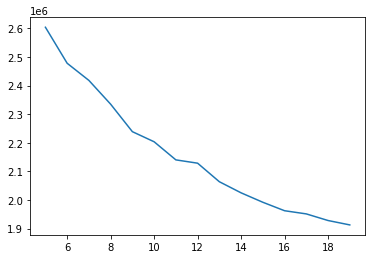

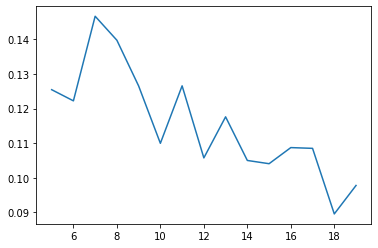

In [13]:
wcss_ef, silhouetteMeasure_ef = errorMeasure(t1, 5, 20, 'euclidean', 'forgy', pairedDistance_euclidean)

### Euclidean distance, Forgy - The point of inflexion for elbow method is at 7 clusters which becomes optimal. The highest silhoette score is at 7 clusters which becomes optimal.  

num Clusters 5
Equilibrium reached - number of iterations and total distance 25 107157.30136080035
wcss 5 2609953.505388931
sil 5 0.15719069519082643
num Clusters 6
Equilibrium reached - number of iterations and total distance 30 103899.15467554277
wcss 6 2508944.1856724126
sil 6 0.128212409722803
num Clusters 7
Equilibrium reached - number of iterations and total distance 70 100669.39324717486
wcss 7 2362857.1003558035
sil 7 0.13345571485393656
num Clusters 8
Equilibrium reached - number of iterations and total distance 23 99355.52847384583
wcss 8 2313283.662554315
sil 8 0.12409480227269673
num Clusters 9
Equilibrium reached - number of iterations and total distance 50 97728.09337995123
wcss 9 2227773.315407418
sil 9 0.13280444260835492
num Clusters 10
Equilibrium reached - number of iterations and total distance 51 96964.57277521511
wcss 10 2217759.1914205197
sil 10 0.11761378052827738
num Clusters 11
Equilibrium reached - number of iterations and total distance 46 95210.55963632108


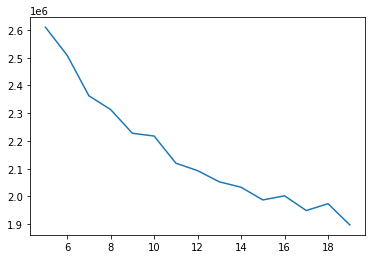

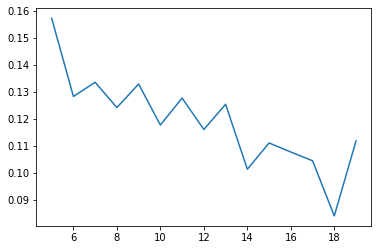

In [14]:
wcss_er, silhouetteMeasure_er = errorMeasure(t1, 5, 20, 'euclidean', 'random', pairedDistance_euclidean)

### Euclidean distance, random partition - The point of inflexion for elbow method is at 7 clusters which becomes optimal. The highest silhoette score is at 5 clusters which becomes optimal.  

In [12]:
import gc
gc.collect()
pairedDistance_manhattan = pairedDistanceMatrix(t1, 'manhattan')

starting paired Distance matrix 5000


num Clusters 5
Equilibrium reached - number of iterations and total distance 13 2009045.6871009772
wcss 5 878703432.4936451
sil 5 0.20486538181944605
num Clusters 6
Equilibrium reached - number of iterations and total distance 17 1990358.1292279945
wcss 6 863056226.7388322
sil 6 0.20362699542473253
num Clusters 7
Equilibrium reached - number of iterations and total distance 47 1884037.730965628
wcss 7 763678434.6552938
sil 7 0.22467450895192181
num Clusters 8
Equilibrium reached - number of iterations and total distance 27 1813941.4992208062
wcss 8 720858219.6793033
sil 8 0.19179323750632704
num Clusters 9
Equilibrium reached - number of iterations and total distance 21 1806270.083971247
wcss 9 704139450.225789
sil 9 0.21097318858470598
num Clusters 10
Equilibrium reached - number of iterations and total distance 30 1738925.2081582379
wcss 10 658086802.3820649
sil 10 0.1969445402163614
num Clusters 11
Equilibrium reached - number of iterations and total distance 29 1688909.7407837647
w

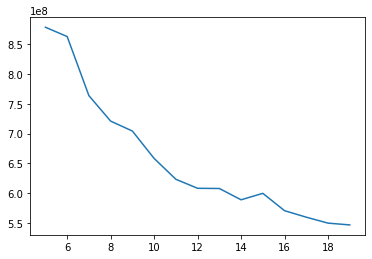

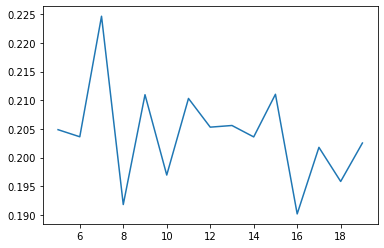

In [22]:
wcss_mf, silhouetteMeasure_mf = errorMeasure(t1, 5, 20, 'manhattan', 'forgy', pairedDistance_manhattan)

### Manhattan distance, Forgy - The point of inflexion for elbow method is at 7 clusters which becomes optimal. The highest silhoette score is at 7 clusters which becomes optimal.  

num Clusters 5
Equilibrium reached - number of iterations and total distance 30 2006837.3074529474
wcss 5 877142912.0701708
sil 5 0.20465611249094195
num Clusters 6
Equilibrium reached - number of iterations and total distance 37 1958428.6183954254
wcss 6 831372688.4527247
sil 6 0.2136015056368453
num Clusters 7
Equilibrium reached - number of iterations and total distance 36 1882955.9769025065
wcss 7 762983042.7232387
sil 7 0.22523522136012075
num Clusters 8
Equilibrium reached - number of iterations and total distance 18 1863771.4214680032
wcss 8 744872498.3025863
sil 8 0.22489471648206705
num Clusters 9
Equilibrium reached - number of iterations and total distance 21 1862853.4950357233
wcss 9 743597277.2122967
sil 9 0.2258090052997377
num Clusters 10
Equilibrium reached - number of iterations and total distance 29 1791546.22228908
wcss 10 693144466.1945261
sil 10 0.19995246644610828
num Clusters 11
Equilibrium reached - number of iterations and total distance 17 1717307.7620371939
w

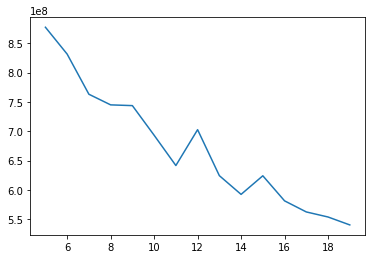

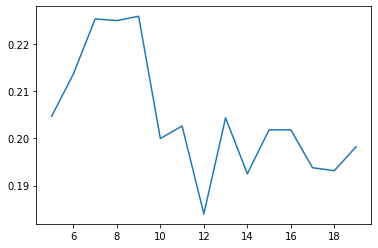

In [38]:
wcss_mr, silhouetteMeasure_mr = errorMeasure(t1, 5, 20, 'manhattan', 'random', pairedDistance_manhattan)

### Manhattan distance, random partition - The point of inflexion for elbow method is at 9 clusters which becomes optimal. The highest silhoette score is at 9 clusters which becomes optimal.  

In [ ]:
import time
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
# X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (10000, 786)


In [ ]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

df_subset = df.loc[rndperm[:10000],:].copy()

data_subset = df_subset[feat_cols].values

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 3.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.898016
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.095825
[t-SNE] KL divergence after 300 iterations: 2.553783
t-SNE done! Time elapsed:

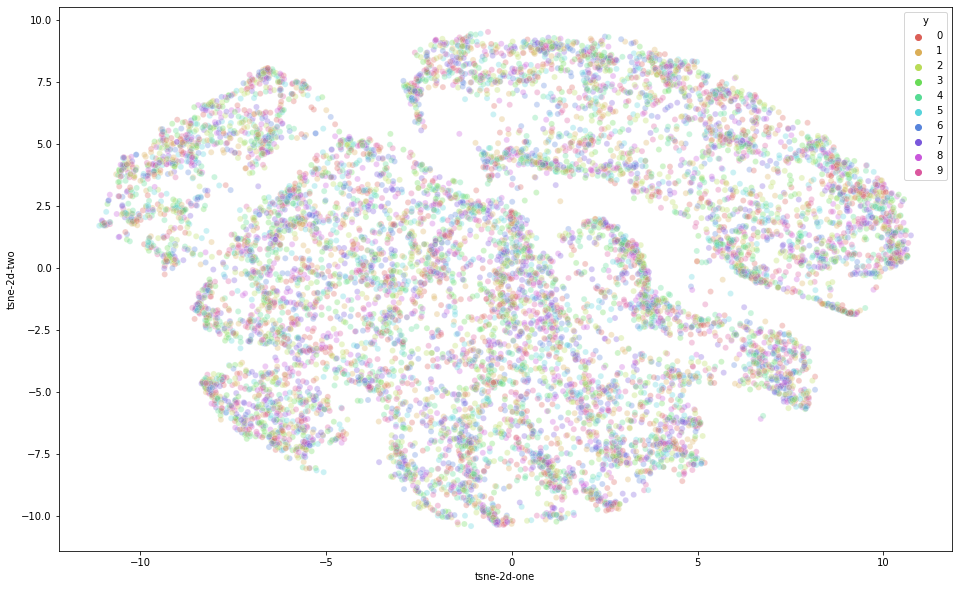

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Hierarchical clustering

In [ ]:
# implement hierarchical clustering ( you can use scikit module)
from sklearn.cluster import AgglomerativeClustering
def hierarchical_clustering():
    # X = np.array([[1, 2], [1, 4], [1, 0],[4, 2], [4, 4], [4, 0]])
    # cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean')
    cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    hclust_fit = cluster.fit(t2)
    hclust_pred = cluster.fit_predict(t2)
    print(hclust_pred)
    return hclust_fit

hierarchical_clustering()

[9923 8903 9960 ...    3    1    0]


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

[9923 8903 9960 ...    3    1    0]


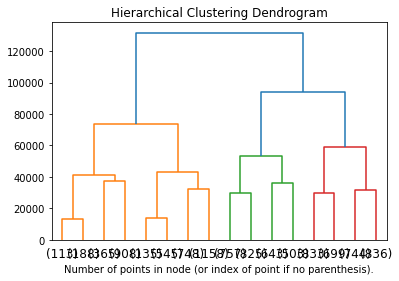

In [ ]:
#visualize a dendogram
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
def print_dendogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = hierarchical_clustering()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
print_dendogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

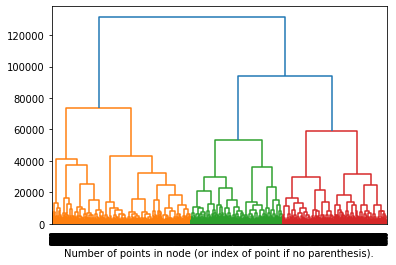

In [ ]:
#printing without truncating
print_dendogram(model)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

Answer: The longest vertical distance without any horizontal line passing through the dendogram is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters. Basically the horizontal line is a threshold, which defines the minimum distance required to be a separate cluster. If we draw a line further down, the threshold required to be a new cluster will be decreased and more clusters will be formed. There is no commonly agreed-upon way to decide where to cut the tree.





[[2.11500000e+03 4.92600000e+03 4.15571895e+01 2.00000000e+00]
 [8.02000000e+02 9.92100000e+03 2.42377804e+02 2.00000000e+00]
 [4.26300000e+03 8.59700000e+03 2.81664694e+02 2.00000000e+00]
 ...
 [7.28100000e+03 1.99950000e+04 2.43168830e+03 9.99800000e+03]
 [6.19100000e+03 1.99960000e+04 2.45433087e+03 9.99900000e+03]
 [1.28600000e+03 1.99970000e+04 2.50245100e+03 1.00000000e+04]]


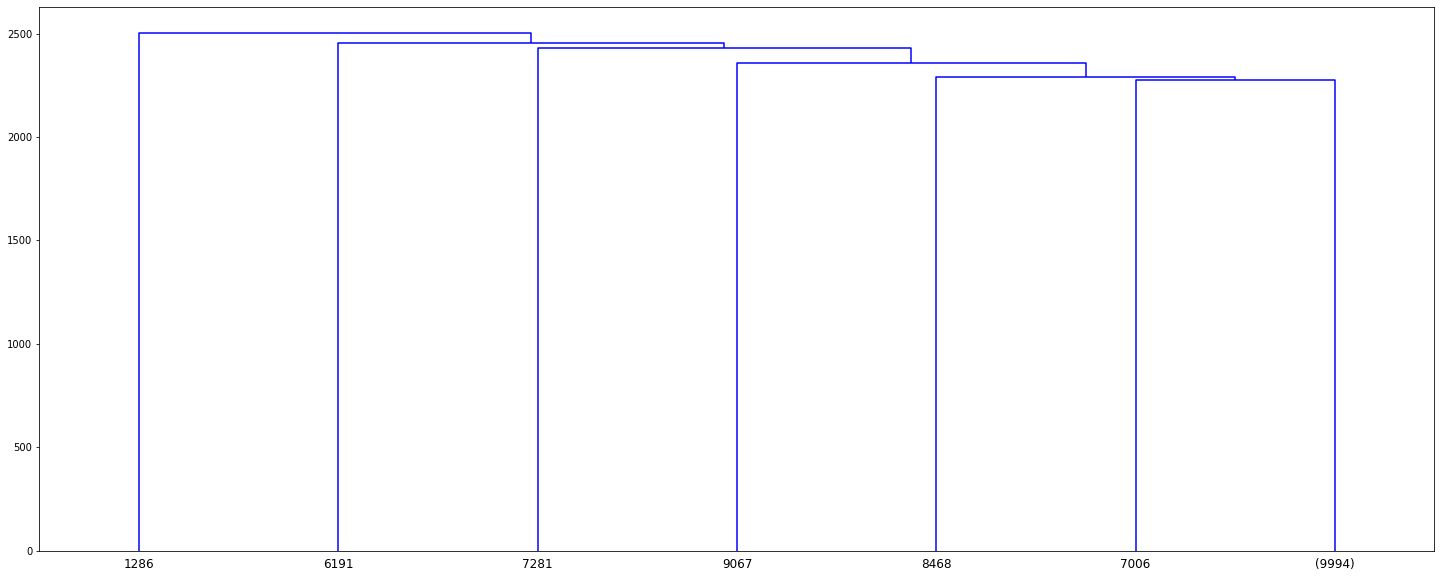

In [ ]:
#visualisation of clusters using single linkage and complete linkage
from scipy.cluster.hierarchy import linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
Z1 = linkage(t2, 'single')
print(Z1)
fig1 = plt.figure(figsize=(25, 10))
dn1 = dendrogram(Z1,  truncate_mode="level", p=5)
plt.show()

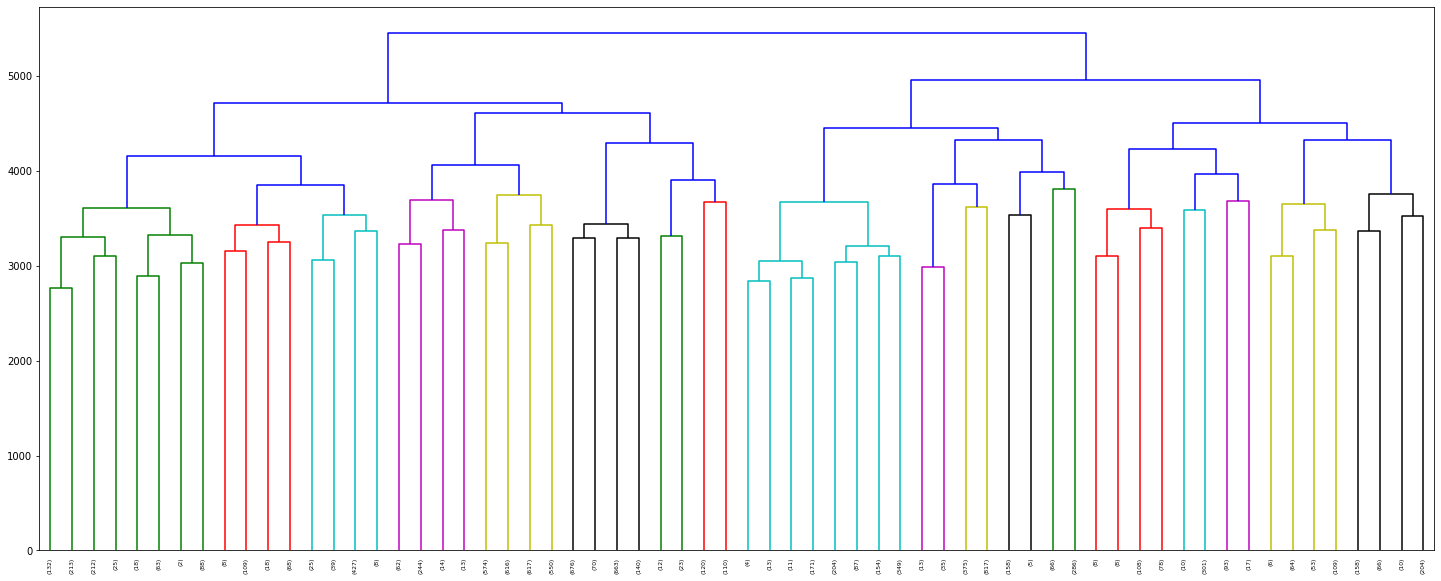

In [ ]:
Z2 = linkage(t2, 'complete')
fig2 = plt.figure(figsize=(25, 10))
dn2 = dendrogram(Z2,  truncate_mode="level", p=5)
plt.show()

**Question:** Mention the differences observed using single and complete linkage:

Answer: In Single Linkage, the distance between two clusters is the minimum distance between members of the two clusters. In Complete Linkage, the distance between two clusters is the maximum distance between members of the two clusters.</br>
We can see that the clustering pattern for complete linkage distance tends to create compact clusters of clusters, while single linkage tends to add one point at a time to the cluster, creating long stringy clusters.